## Семинар 4: "Сверточные сети"

In [1]:
from __future__ import division
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from sklearn.metrics import classification_report
from timeit import default_timer as timer
import sys
%matplotlib inline
import gc

/Users/penzardmitry/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [2]:
def t_convolve(signal, kernel):
    kernel_flip = kernel[::-1]
    
    w = kernel.size
    result = np.zeros(signal.size - w + 1)
    for mid in xrange(signal.size - w  + 1):
        result[mid] = np.sum(signal[mid : mid + w] * kernel_flip)
    return result

Проверим правильность реализации, сравнив с реализацией из scipy

In [3]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')
np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

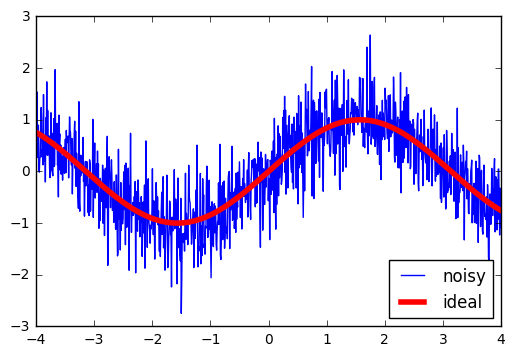

In [4]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
y = signal
noisy_signal = signal + np.random.randn(y.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

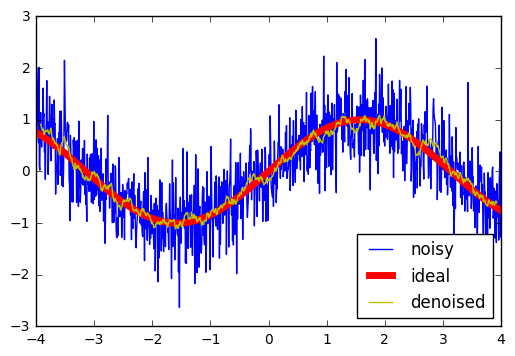

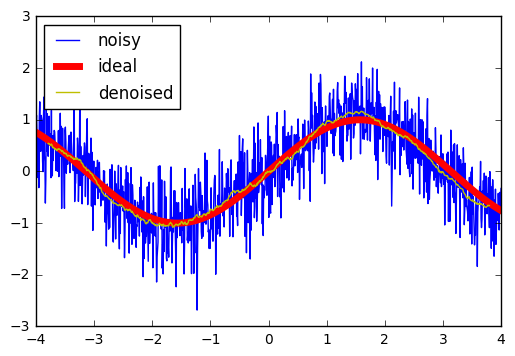

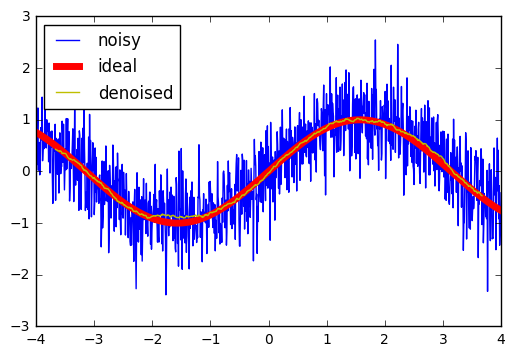

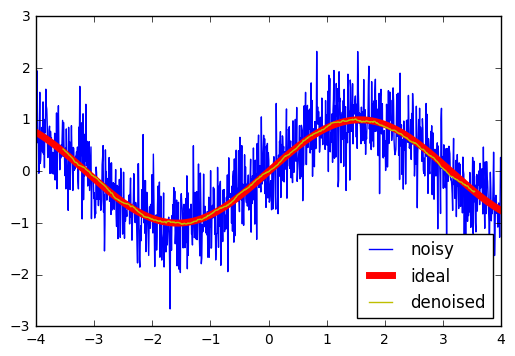

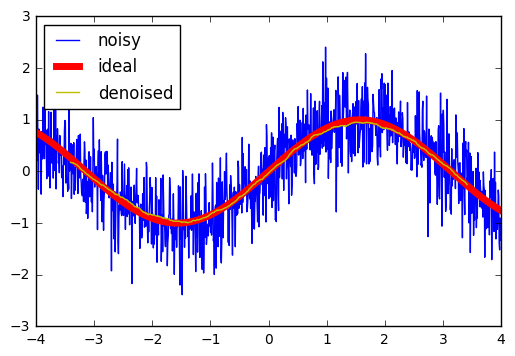

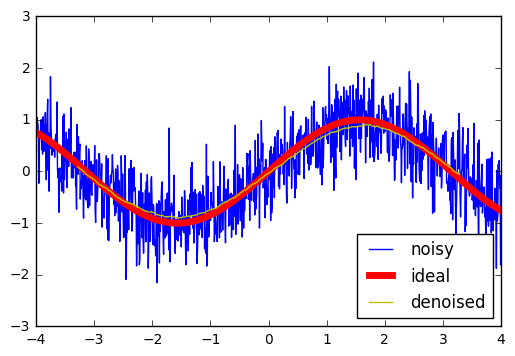

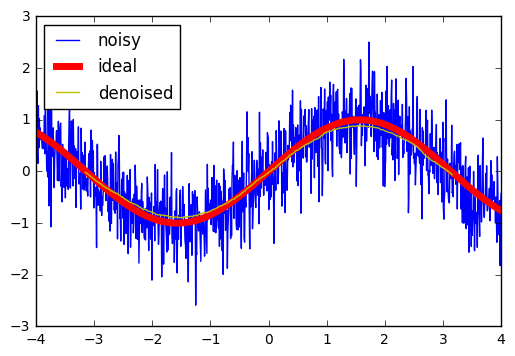

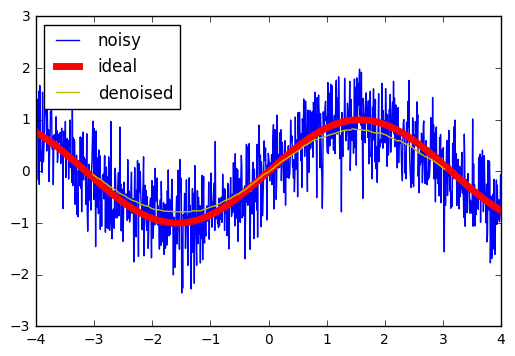

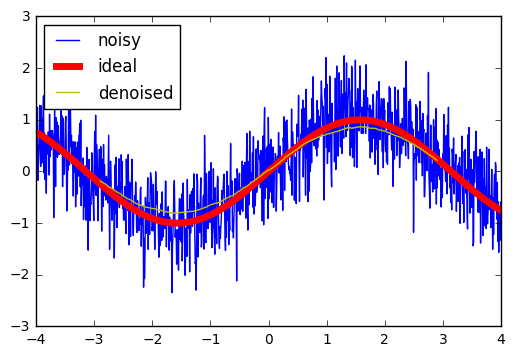

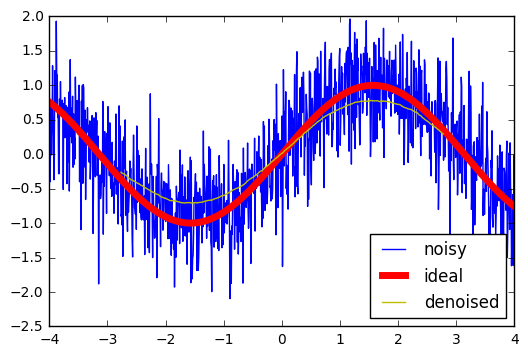

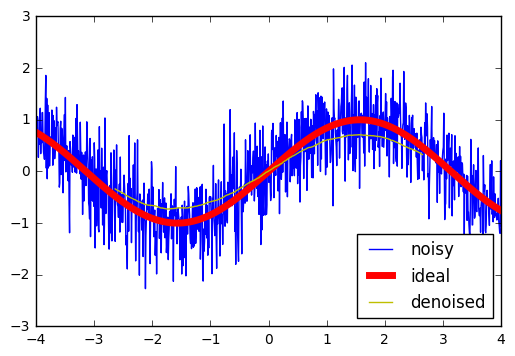

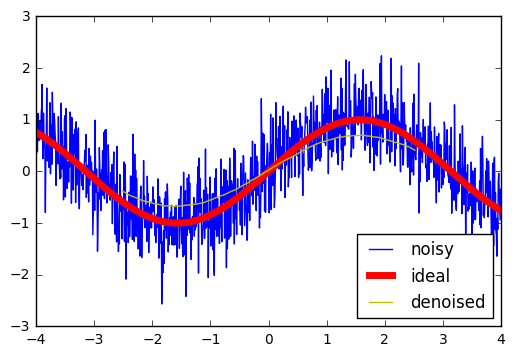

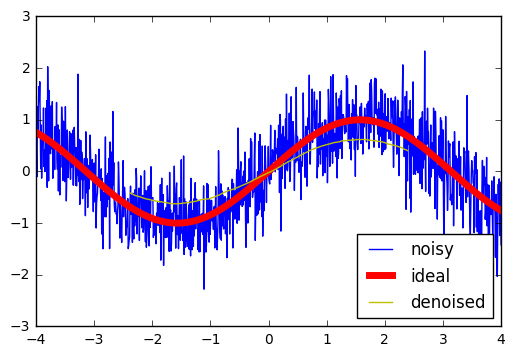

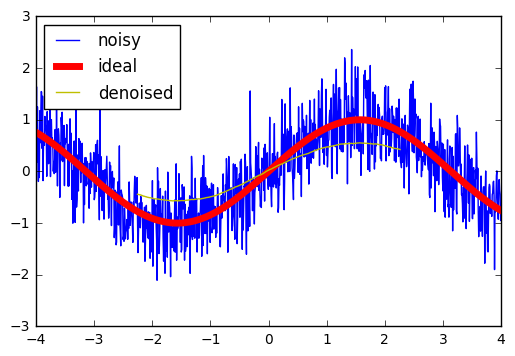

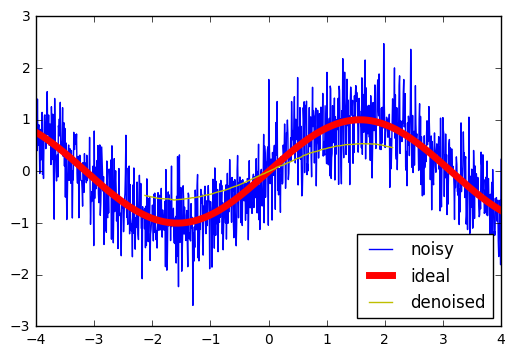

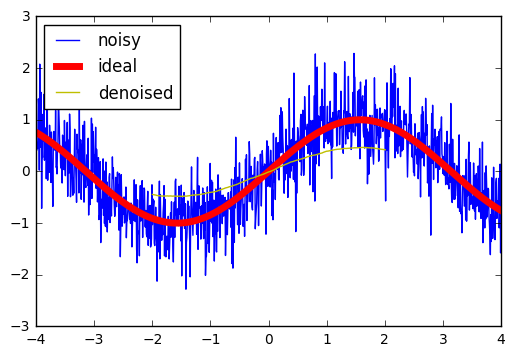

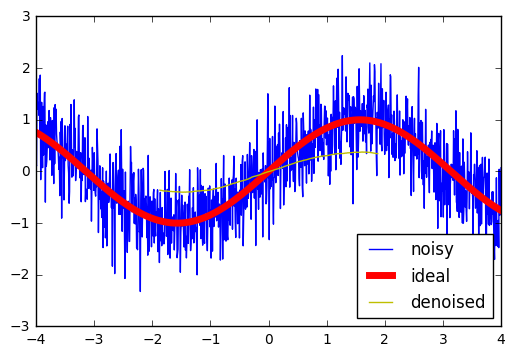

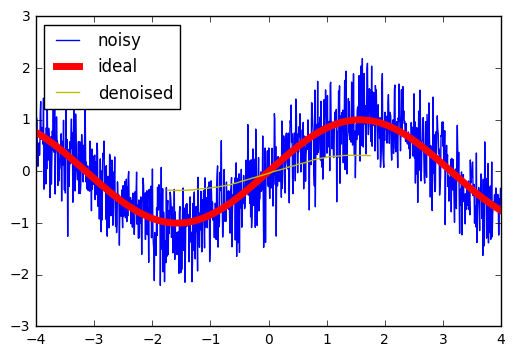

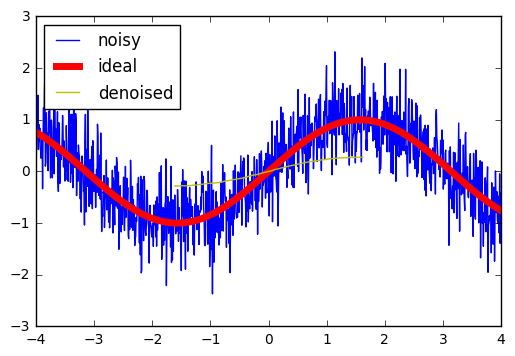

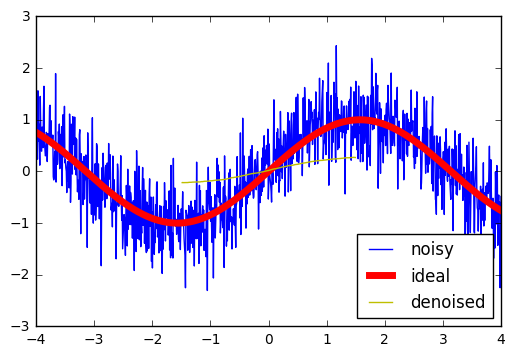

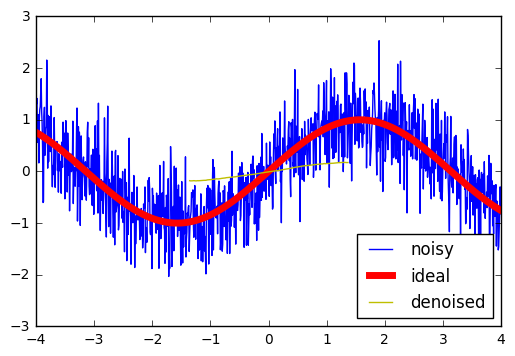

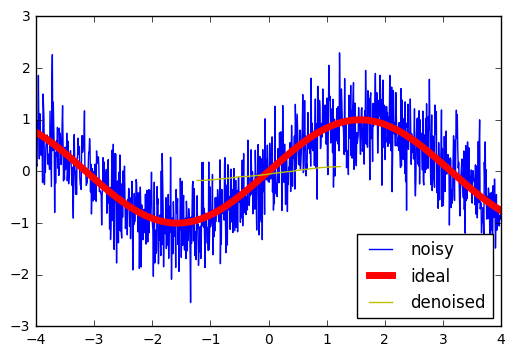

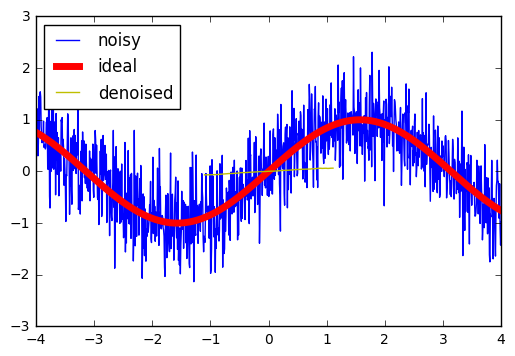

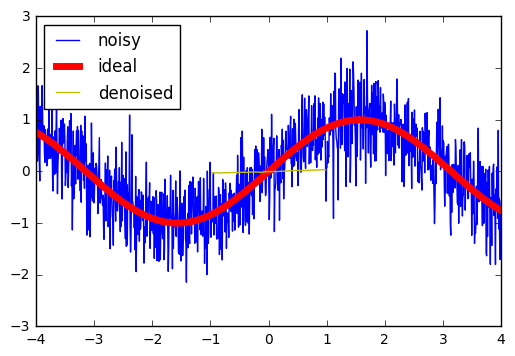

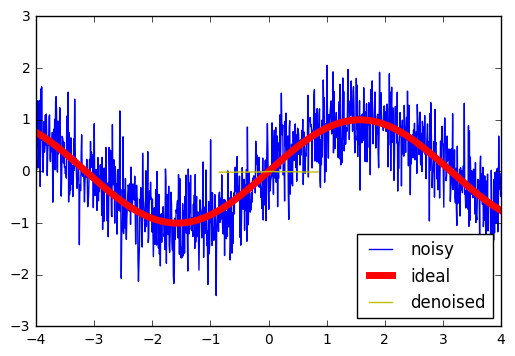

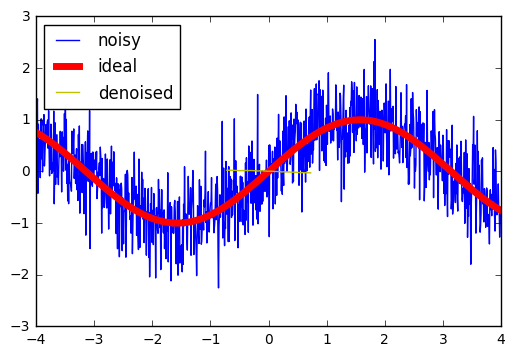

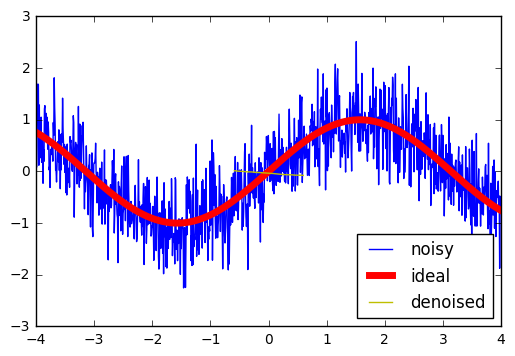

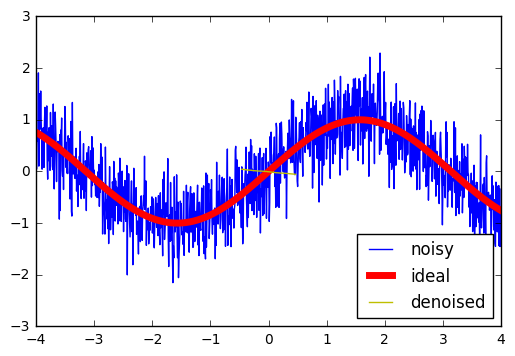

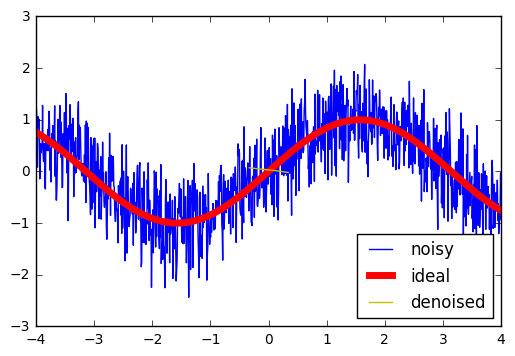

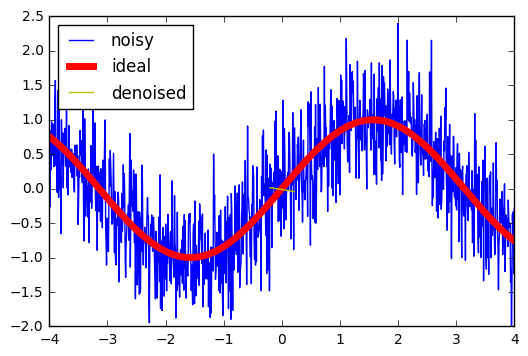

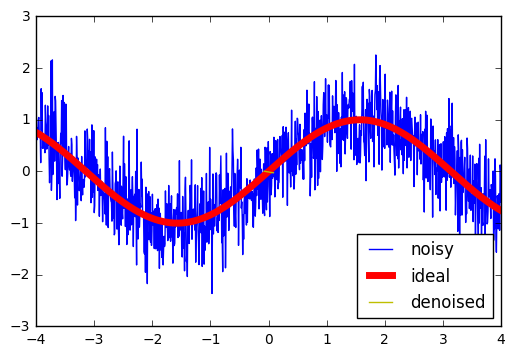

In [5]:

for w in range(20, 1000, 32):

    x = np.linspace(-4, 4, 1000)
    signal = np.sin(x)
    noisy_signal = signal + np.random.randn( noisy_signal.shape[0])*0.5  
    
    kernel = np.array([1. / w for i in range(w)])
    denoised_signal = convolve(noisy_signal, kernel, mode='valid')
    plt.plot(x, noisy_signal, label='noisy')
    plt.plot(x, signal, 'r', label='ideal', linewidth=5)
    plt.plot(x[ (w // 2 ) :- (w // 2 - 1)], denoised_signal, 'y', label='denoised')
    plt.legend(loc=0)
    plt.show()


Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

In [6]:
### YOUR CODE HERE #####

#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

<i>1.4 Реализуйте функцию, вычисляющую свертку массивов произвольных размерностей.</i>

In [7]:
from itertools import product, izip

def t_convolve_multid(signal, kernel):

    assert signal.ndim == kernel.ndim
    reverse = [slice(None, None, -1)] * kernel.ndim
    kernel = kernel[reverse]    
    result_signal = np.zeros(shape =[(size - w  + 1) for w, size in izip(kernel.shape, signal.shape)])
    
    possible_points = product(*[[i for i in xrange(size - w  + 1)] for w, size in izip(kernel.shape, signal.shape)])
    for point in possible_points:
        result_signal[point] = (signal[ [slice(coord, w + coord) for w, coord in izip(kernel.shape, point) ]] * kernel).sum()
        

    
    return result_signal

In [8]:
signal = np.random.rand(100, 30, 20)
kernel = np.random.rand(10, 3, 5)
t_result = t_convolve_multid(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>1.5 Найдите в вашей любимой поисковой системе коэффициенты каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [11]:
color_to_bw = np.array([0.299 , 0.587, 0.114]).reshape(1,1,3)


#0.299 R + 0.587 G + 0.114 B

<i>1.6 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

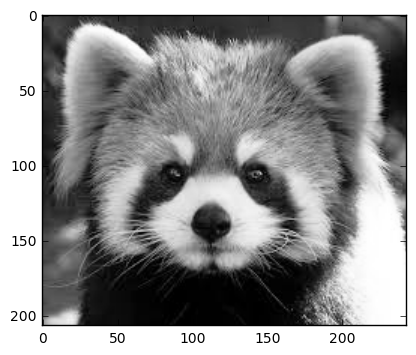

In [12]:
import matplotlib.image as image
img = image.imread("images.jpeg")

#plt.imshow(img)
plt.imshow(t_convolve_multid(img, color_to_bw)[:,:,0], cmap=plt.cm.Greys_r)

Операция свертки позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.7 Задайте ядро фильтра Собеля и продемонстрируйте результат его применения к любому цветному изображению.</i>

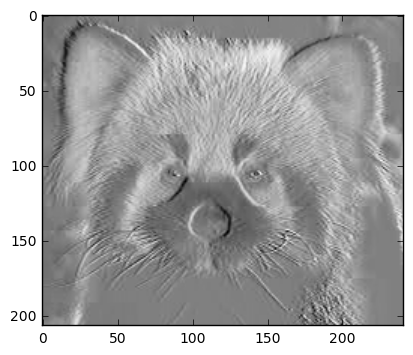

In [13]:
color_to_bw = np.array([-2 , -2, -0, -2, 0, 2, 0, 2, 2]).reshape(1,3,3)
sob_img = t_convolve_multid(img, color_to_bw)
plt.imshow(sob_img[:,:,0], cmap=plt.cm.Greys_r)

В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

<i>1.8 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

In [14]:
def t_convolve_bank(signal, kernel_arr):
    assert signal.ndim == kernel_arr.ndim - 1
    result = np.zeros(signal.shape[:-1] + (kernel_arr.shape[0],), signal.dtype)
    result = list()
    for i in range(kernel_arr.shape[0]):
        result.append(convolve(signal, kernel_arr[i, ::-1, ::-1], mode = "valid"))
    result = np.concatenate(result, axis = -1)
    return result



In [15]:
def t_convolve_bank(signal, kernels):
    # signal.shape = (sy, sx, n_layers)
    # kernels.shape = (n_filters, ky, kx, n_layers)
    assert signal.ndim == kernels.ndim - 1
    
    conv = np.zeros(signal.shape[:-1] + (kernels.shape[0],), signal.dtype)
    for i in range(kernels.shape[0]):
        conv[:, :, i] = convolve(signal, kernels[i, ::-1, ::-1], mode='valid')[:,:,0]
        print convolve(signal, kernels[i, ::-1, ::-1], mode='valid').shape
    return conv

<i>1.9 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

In [16]:
rgb_to_bgr = np.identity(3).reshape(3, 1, 1, 3)

<i>1.10 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

(207, 243, 1)
(207, 243, 1)
(207, 243, 1)
(207, 243, 3)


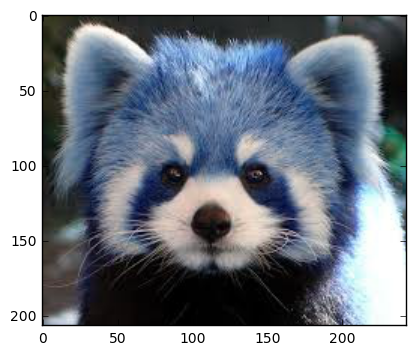

In [17]:
plt.imshow(t_convolve_bank(img, rgb_to_bgr).astype('uint8'))
print img.shape

В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [18]:
def pool(img, pool_w, function):
    assert(img.ndim == 3)
    assert(len(pool_w) == 2)
    assert img.shape[0] % pool_w[0] == 0 and img.shape[1] % pool_w[1] == 0
    assert function(img[0:pool_w[0], 0:pool_w[1], 0]).size == 1
                        
    pool_img = np.zeros(shape = (img.shape[0] / pool_w[0], img.shape[1] / pool_w[1], img.shape[2]))
    for i in range(pool_img.shape[2]):
        for j, k in np.ndindex(pool_img.shape[0:2]):
            pool_img[j, k, i] = function(img[j * pool_w[0] : (j + 1) * pool_w[0],
                                             k * pool_w[1] : (k + 1) * pool_w[1],
                                             i])
    return pool_img

def max_pool(image, pool_w = (3,3)):
    return pool(image, pool_w, np.max).astype('uint8')

def median_pool(image, pool_w =(3,3)):
    return pool(image, pool_w, np.median).astype('uint8')

Как и в первой части, посмотрим сначала как эта опреация влияет на цветные изображения.

<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>

/Users/penzardmitry/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


NOTE: MaxPool fails to eliminate white pixels of noise. In fact, per channel Max Pool adds noise here.


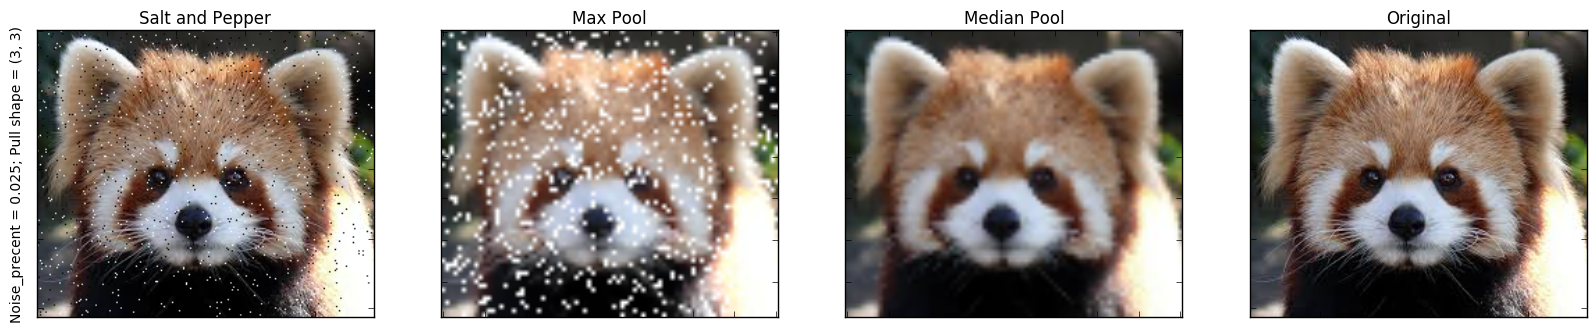

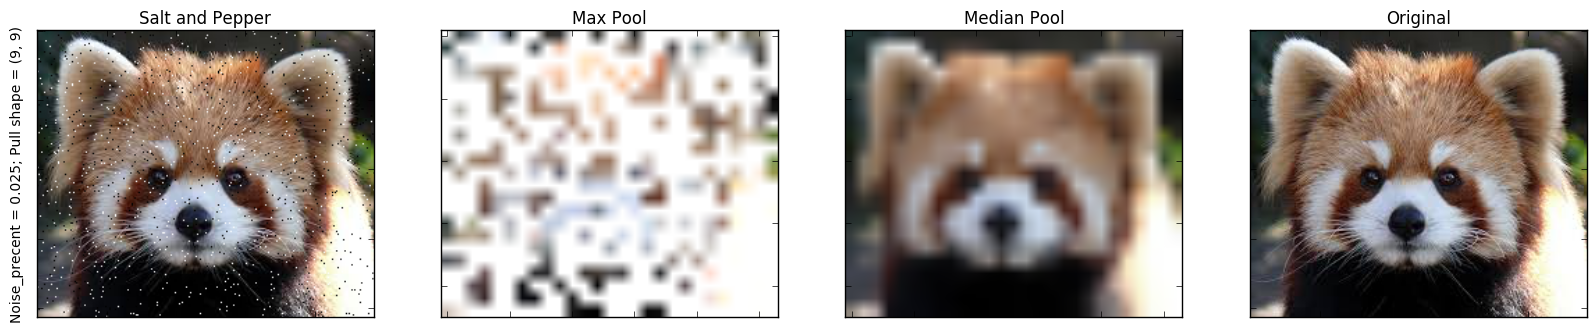

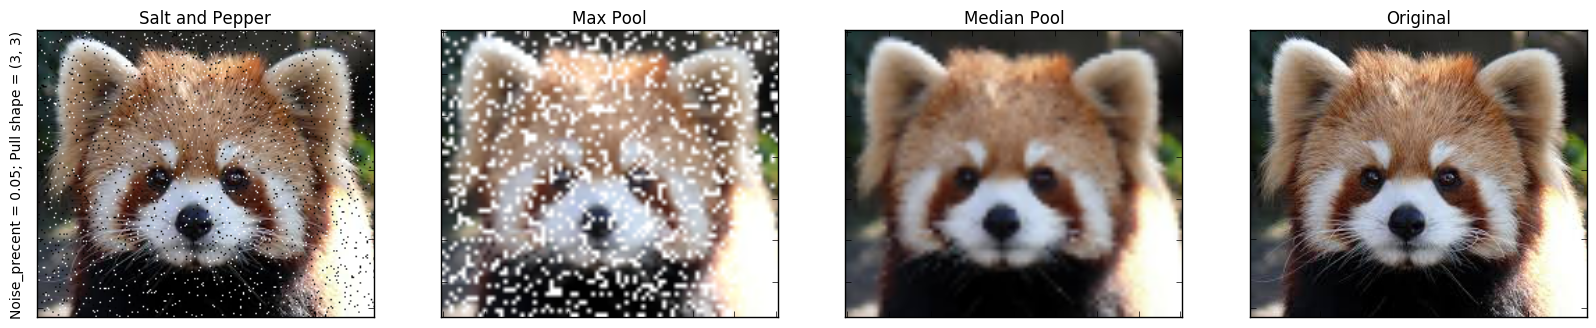

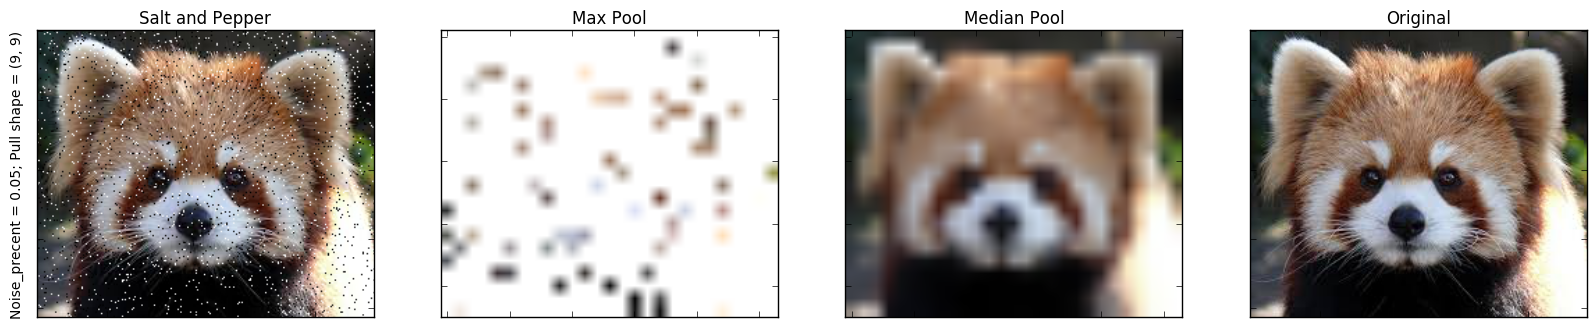

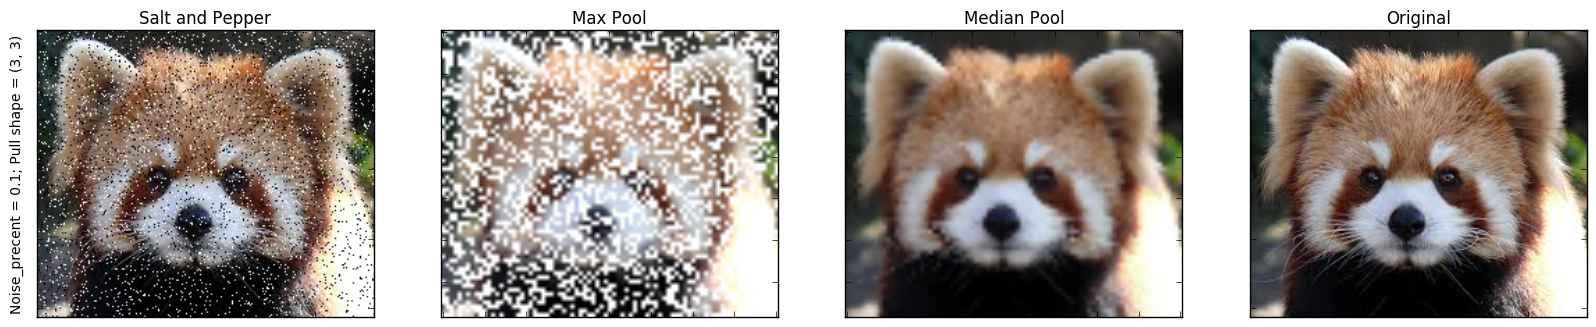

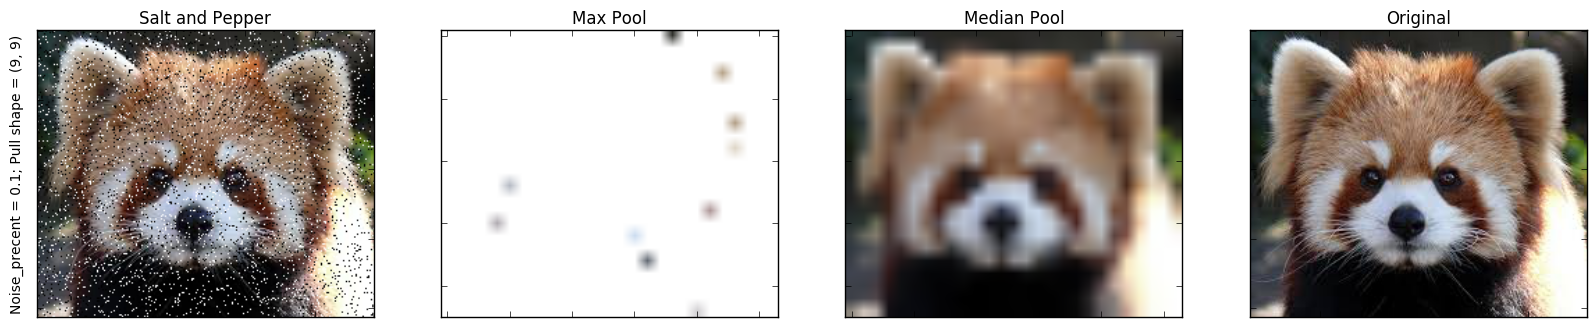

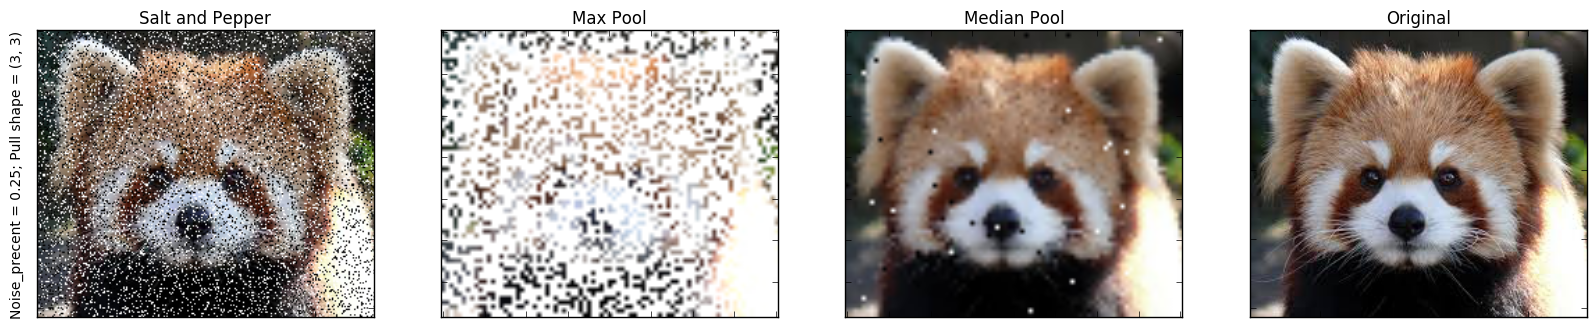

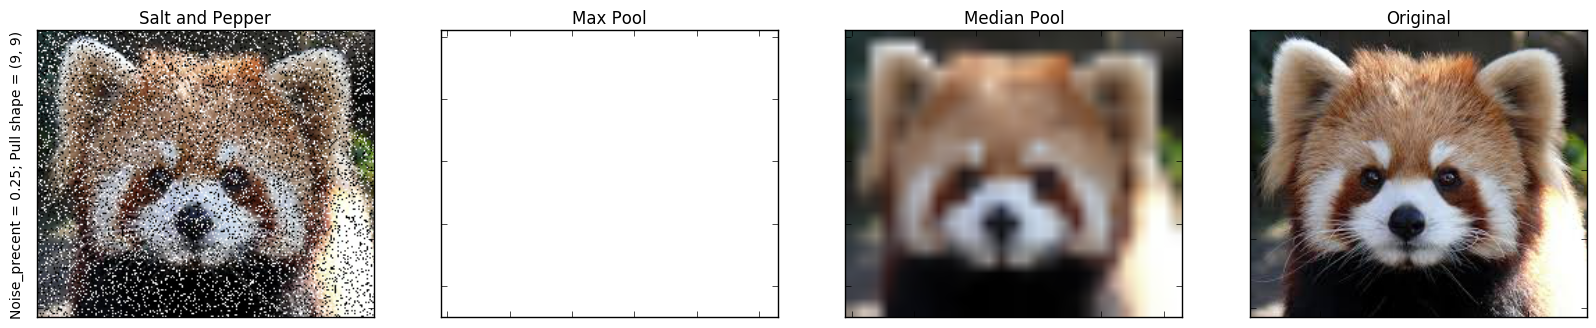

In [19]:
def get_salt_and_pepper(img, noise_percent = 0.10):
    
    assert img.ndim == 3
    rand_n = np.random.uniform(size = img.shape[:2])
    white = np.array([255,255,255])
    black = np.array([0, 0,0])

    salt = rand_n < (noise_percent / 2) 
    pepper = rand_n > (1 - (noise_percent / 2))
    
    #print "Salt", salt.sum()
    #print "Black", pepper.sum()
    img_sp = img.copy()
    img_sp[salt] = white
    img_sp[pepper] = black
    
    return img_sp.astype('uint8')



def get_image_layer(noise_percent = 0.05, pull_shape = (3,3)):
    img_sp = get_salt_and_pepper(img, noise_percent=noise_percent)
    grid, plot_arr = plt.subplots(1, 4, figsize=(20, 10))
    
    for ax in grid.axes:
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])

    plot_arr[0].imshow(img_sp)
    plot_arr[0].set_title('Salt and Pepper')
    plot_arr[0].set_ylabel('Noise_precent = {0}; Pull shape = {1}'.format(noise_percent, pull_shape))

    plot_arr[1].imshow(max_pool(img_sp, pool_w = pull_shape))
    plot_arr[1].set_title('Max Pool')

    plot_arr[2].imshow(median_pool(img_sp, pool_w = pull_shape))
    plot_arr[2].set_title('Median Pool')

    plot_arr[3].imshow(img)
    plot_arr[3].set_title('Original')

for noise_percent in (0.025, 0.05, 0.10, 0.25):
    for pull_shape in ((3,3), (9,9)):
        get_image_layer(noise_percent, pull_shape)

print('NOTE: MaxPool fails to eliminate white pixels of noise. In fact, per channel Max Pool adds noise here.')

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST

(70000,)
[6903 7877 6990 7141 6824 6313 6876 7293 6825 6958]


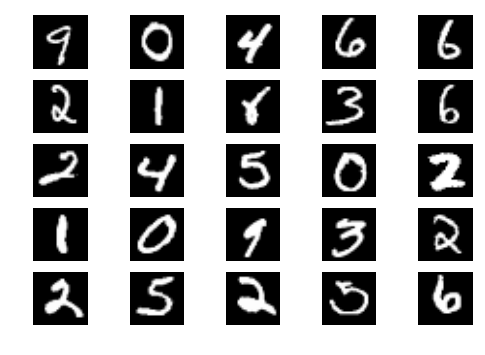

In [2]:
# обратите внимание, что данные имеют размерость examples x channels x w x h
mnist = fetch_mldata('MNIST original')
images = mnist['data']
images = images.reshape(images.shape[0], 1, 28, 28)
labels = mnist['target'].astype(int)

print labels.shape

print np.bincount(labels)
images_train, images_test, labels_train, labels_test = train_test_split(images, labels)
for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images_train[i, 0, :, :], cmap=plt.cm.Greys_r)
    plt.axis('off')
    
images_train =  torch.from_numpy(images_train).type(torch.FloatTensor)
images_test =  torch.from_numpy(images_test).type(torch.FloatTensor)
labels_train =  torch.from_numpy(labels_train)
labels_test =  torch.from_numpy(labels_test)

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 conv 3x3 -> ReLU -> maxpool -> 16 conv 3x3 -> softmax
1. input -> 8 conv 3x3 -> ReLU -> 16 conv 3x3 -> ReLU -> maxpool -> 32 conv 3x3 -> softmax

* nn.functional.conv2d
* nn.MaxPool2d
* nn.Reshape (чтобы перевести изображения в вектор)

Документация: http://pytorch.org/docs/

<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

In [3]:

image_size = images_train.size(2)
channels = images_train.size(1)
kernel_size = (3, 3)

class Neuro_Arch1(nn.Module):
    def __init__(self):
        super(Neuro_Arch1, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 8, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 3, padding=1)
        )
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2 * 16, 10), 
                                           nn.LogSoftmax())
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x


class Neuro_Arch2(nn.Module):
    def __init__(self):
        super(Neuro_Arch2, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 8, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1)
        )
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2 * 32 , 10), 
                                           nn.LogSoftmax())

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [4]:
#was copied from previous homework
def print_work_time(func):
    def wrapper(*args, **kwargs):
        start = timer()
        result = func(*args, **kwargs)
        end = timer()
        print("Execution take {}".format(end - start))
        return result
    return wrapper

@print_work_time
def learn_on_model(X, Y, model, loss_fn, X_test = None, Y_test = None, learning_rate = 1e-2, 
                   batch_size = 100, max_epoch_num = 1, min_loss = 1e-3): 
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)    
    loss = 1000
    epoch_num = 0
     
    loss_arr = list()

    test_loss_arr = list() if not (type(X_test) is None) else None
    tot_err = 10**6
    
    while tot_err > min_loss and epoch_num < max_epoch_num:
        tot_err = 0
        sys.stdout.write("Epoch {} ...\n".format(epoch_num + 1))
        for bn, start in enumerate(xrange(0, X.size()[0], batch_size)):
            optimizer.zero_grad()
            if bn % 100 == 0:
                sys.stdout.write("Train Batch {}\n".format(bn))
            X_CUR = Variable(X[start:start + batch_size])
            Y_CUR = Variable(Y[start:start + batch_size], requires_grad=False)
            output =  model.forward(X_CUR)
            loss = loss_fn(output, Y_CUR)
            loss_arr.append(loss.data.tolist()[0])
            tot_err += loss
            loss.backward()
            optimizer.step()
            del loss
            del X_CUR
            del Y_CUR
            del output

        
        if not (type(X_test) is None):
            for bn, start in enumerate(xrange(0, X_test.size()[0], batch_size)):
                if bn % 100 == 0:
                    sys.stdout.write("Test Batch {}\n".format(bn))
                X_CUR = Variable(X_test[start:start + batch_size])
                Y_CUR = Variable(Y_test[start:start + batch_size])
                y_pred = model.forward(X_CUR)
                loss = loss_fn(y_pred, Y_CUR)
                test_loss_arr.append(loss.data.tolist()[0])
                del X_CUR
                del Y_CUR
                del y_pred
                del loss
            
            
        epoch_num += 1
        gc.collect() # only this've helped to save process from beeing kill
    return np.array(loss_arr), np.array(test_loss_arr)

def draw_plots(model, loss_arr, layer_arr, test_loss_arr, show_weights = False):
    x = np.arange(loss_arr.shape[0]);
    number_of_plots = 1 + sum(len(x) for x in layer_arr)
    gridSize = number_of_plots
    plt.figure(figsize=(15, 6 * number_of_plots))
    
    plotId = 1
    subpl = plt.subplot(gridSize, 1, plotId)
    if not type(test_loss_arr) is None:
        subpl.plot(x, loss_arr, x, test_loss_arr)
        subpl.legend(["Train", "Test"])
    else:
        subpl.plot(x, loss_arr)
    subpl.set_xticks(range(x.shape[0]))
    subpl.set_title("Loss function")
    subpl.set_xlabel("Epoch num")
    subpl.set_ylabel("Loss func")
    if show_weights:
        for ind1, child in enumerate(model.children()):
            for ind2, key in enumerate(child.state_dict().keys()):
                plotId += 1
                subpl = plt.subplot(gridSize, 1, plotId)
                y = layer_arr[ind1][ind2]
                subpl.plot(x, y)

                subpl.set_xticks(range(x.shape[0]))
                subpl.set_title("Layer {} : {} gradient norm".format(ind1 + 1, key))
                subpl.set_xlabel("Epoch num")
                subpl.set_ylabel(key + "_grad")
    
    plt.show()

from sklearn.metrics import classification_report

def make_classification_report(model, X_TRAIN, Y_TRAIN, X_TEST, Y_TEST, batch_size = 100):
    print ("Train report")
    y_predicted = np.zeros(shape = (Y_TRAIN.size()[0], 10))
    
    for bn, start in enumerate(xrange(0, X_TRAIN.size()[0], batch_size)):
        if bn % 100 == 0:
            sys.stdout.write("Batch {}\n".format(bn))
        X_CUR = Variable(X_TRAIN[start:start + batch_size])
        
        
        y_predicted[start:start + batch_size] = np.array(model.forward(X_CUR).data.tolist())
    indices = np.argmax(y_predicted, axis = 1)
    print (classification_report(np.array(Y_TRAIN.tolist()), indices))
    print ("Accuracy", np.mean(np.array(Y_TRAIN.tolist()) == indices))
    
    print ("Test report")
    y_predicted = np.zeros(shape = (Y_TEST.size()[0], 10))
    for bn, start in enumerate(xrange(0, X_TEST.size()[0], batch_size)):
        if bn % 100 == 0:
            sys.stdout.write("Batch {}\n".format(bn))
        X_CUR = Variable(X_TEST[start:start + batch_size])
        y_predicted[start:start + batch_size] = np.array(model.forward(X_CUR).data.tolist())
        del X_CUR
        
    
    
    indices = np.argmax(y_predicted, axis = 1)
    print (classification_report(np.array(Y_TEST.tolist()), indices))
    print ("Accuracy", np.mean(np.array(Y_TEST.tolist()) == indices))

    


In [64]:
model = Neuro_Arch1()
loss_fn = torch.nn.NLLLoss(size_average=True)


learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


loss_arr, test_loss_arr = learn_on_model( images_train, labels_train, model, loss_fn,images_test,\
                                                    labels_test,\
                                                    learning_rate,\
                                                    max_epoch_num=15, batch_size = 32)



Epoch 1 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Train Batch 1100
Train Batch 1200
Train Batch 1300
Train Batch 1400
Train Batch 1500
Train Batch 1600
Test Batch 0
Test Batch 100
Test Batch 200
Test Batch 300
Test Batch 400
Test Batch 500
Epoch 2 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Train Batch 1100
Train Batch 1200
Train Batch 1300
Train Batch 1400
Train Batch 1500
Train Batch 1600
Test Batch 0
Test Batch 100
Test Batch 200
Test Batch 300
Test Batch 400
Test Batch 500
Epoch 3 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Train Batch 1100
Train Batch 1200
Train Batch 1300
Train Ba

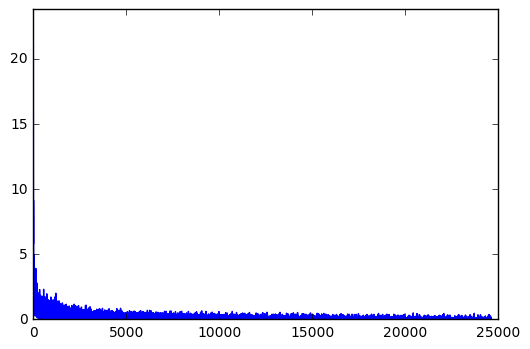

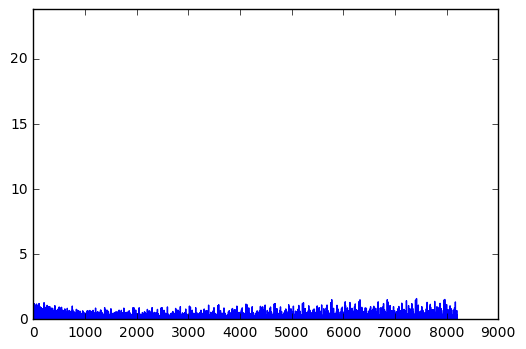

Train report
Batch 0
Batch 100
Batch 200
Batch 300
Batch 400
Batch 500
             precision    recall  f1-score   support

          0       0.99      1.00      1.00      5214
          1       0.98      1.00      0.99      5852
          2       0.99      0.99      0.99      5259
          3       0.99      0.99      0.99      5378
          4       0.97      1.00      0.98      5129
          5       0.99      0.99      0.99      4744
          6       1.00      0.98      0.99      5191
          7       0.99      0.99      0.99      5492
          8       0.99      0.98      0.99      5080
          9       1.00      0.97      0.98      5161

avg / total       0.99      0.99      0.99     52500

('Accuracy', 0.98982857142857139)
Test report
Batch 0
Batch 100
             precision    recall  f1-score   support

          0       0.98      0.99      0.98      1689
          1       0.96      0.99      0.98      2025
          2       0.97      0.96      0.96      1731
          3  

In [65]:
mx = np.max([np.max(test_loss_arr), np.max(loss_arr)])
plt.plot(loss_arr)
plt.ylim( (0, mx))
plt.show()


plt.plot(test_loss_arr)
plt.ylim( (0, mx))
plt.show()

make_classification_report(model, images_train, labels_train, images_test, labels_test)

Чтобы посчитать следующую сеть пришлось сохранять каждый шаг обучения и в случае падения ядра перезапускать обучение с момента остановки

In [5]:
MAX_EPOCH_NUM = 15
MAX_HANDLE = 1




loss_fn = torch.nn.NLLLoss(size_average=True)

learning_rate = 1e-4

  
try:
    model = torch.load("model.txt")
    loss_arr = np.load("loss_arr.txt.npy")
    test_loss_arr = np.load("test_arr.txt.npy")
    epoch = np.load("epoch_num.txt.npy")
    images_train = torch.load("images_train.txt")
    labels_train = torch.load("labels_train.txt")
    images_test = torch.load("images_test.txt")
    labels_test = torch.load("labels_test.txt")
except:
    #there is no need to load data
    model = Neuro_Arch2()
    loss_arr= None
    test_loss_arr = None
    epoch = 0
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

while epoch < MAX_EPOCH_NUM:
    print epoch
    sub_loss_arr, sub_test_loss_arr = learn_on_model( images_train, labels_train, model, loss_fn,images_test,\
                                                    labels_test,\
                                                    learning_rate,\
                                                    max_epoch_num=MAX_HANDLE, batch_size = 32)
    if not loss_arr is None:
        print loss_arr.shape
        print test_loss_arr.shape
        torch.save(images_train, "images_train.txt")
        torch.save(labels_train, "labels_train.txt")
        torch.save(images_test, "images_test.txt")
        torch.save(labels_test, "labels_test.txt")
        loss_arr = np.concatenate([loss_arr, sub_loss_arr])
        test_loss_arr = np.concatenate([test_loss_arr, sub_test_loss_arr])
    else:
        loss_arr = sub_loss_arr
        test_loss_arr = sub_test_loss_arr
    epoch += 1
    np.save("loss_arr.txt", loss_arr)
    np.save("test_arr.txt", test_loss_arr)
    np.save("epoch_num.txt", epoch)
    torch.save(model, "model.txt")

13
Epoch 1 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Train Batch 1100
Train Batch 1200
Train Batch 1300
Train Batch 1400
Train Batch 1500
Train Batch 1600
Test Batch 0
Test Batch 100
Test Batch 200
Test Batch 300
Test Batch 400
Test Batch 500
Execution take 271.638761997
(21333,)
(7111,)


/Users/penzardmitry/anaconda/lib/python2.7/site-packages/torch/serialization.py:146: UserWarning: Couldn't retrieve source code for container of type Neuro_Arch2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


14
Epoch 1 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Train Batch 1100
Train Batch 1200
Train Batch 1300
Train Batch 1400
Train Batch 1500
Train Batch 1600
Test Batch 0
Test Batch 100
Test Batch 200
Test Batch 300
Test Batch 400
Test Batch 500
Execution take 295.147069931
(22974,)
(7658,)


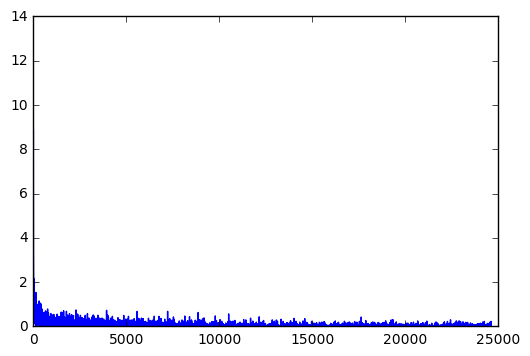

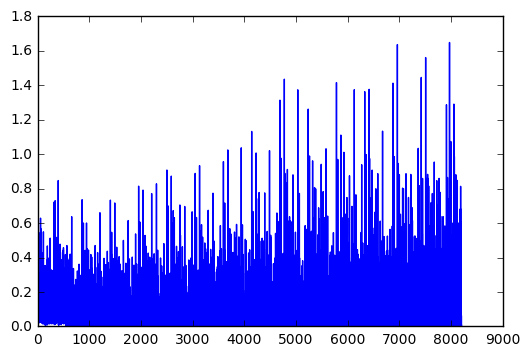

Train report
Batch 0
Batch 100
Batch 200
Batch 300
Batch 400
Batch 500
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      5166
          1       1.00      1.00      1.00      5982
          2       1.00      1.00      1.00      5198
          3       1.00      1.00      1.00      5329
          4       1.00      1.00      1.00      5055
          5       1.00      1.00      1.00      4759
          6       1.00      1.00      1.00      5171
          7       1.00      1.00      1.00      5478
          8       1.00      1.00      1.00      5083
          9       1.00      1.00      1.00      5279

avg / total       1.00      1.00      1.00     52500

('Accuracy', 0.9983238095238095)
Test report
Batch 0
Batch 100
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      1737
          1       0.99      0.99      0.99      1895
          2       0.97      0.98      0.97      1792
          3   

In [6]:
plt.plot(loss_arr)
plt.show()

plt.plot(test_loss_arr)
plt.show()

make_classification_report(model, images_train, labels_train, images_test, labels_test)

<i>3.2 На каких объектах сеть ошибается сильнее всего?</i>

Зависит от сети. Первая больше всего ошибалась на 4, вторая - на 2 и 8. Видно, что наша сеть стала переобучаться в случае второй архитектуры.

<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

In [14]:
# Попробуем такую нейросеть - оставим только два сверточных слоя (среднее между двумя имевшимися ранее и посмотрим, как она обучится)
class Neuro_Arch3(nn.Module):
    def __init__(self):
        super(Neuro_Arch3, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 8, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 3, padding=1),
        )
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2 * 16 , 10), 
                                           nn.LogSoftmax())

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [12]:
model = Neuro_Arch3()
loss_fn = torch.nn.NLLLoss(size_average=True)


learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


loss_arr, test_loss_arr = learn_on_model( images_train, labels_train, model, loss_fn,images_test,\
                                                    labels_test,\
                                                    learning_rate,\
                                                    max_epoch_num=15, batch_size = 32)

Epoch 1 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Train Batch 1100
Train Batch 1200
Train Batch 1300
Train Batch 1400
Train Batch 1500
Train Batch 1600
Test Batch 0
Test Batch 100
Test Batch 200
Test Batch 300
Test Batch 400
Test Batch 500
Epoch 2 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Train Batch 1100
Train Batch 1200
Train Batch 1300
Train Batch 1400
Train Batch 1500
Train Batch 1600
Test Batch 0
Test Batch 100
Test Batch 200
Test Batch 300
Test Batch 400
Test Batch 500
Epoch 3 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Train Batch 1100
Train Batch 1200
Train Batch 1300
Train Ba

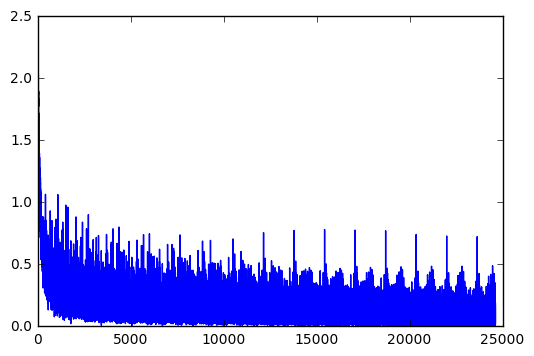

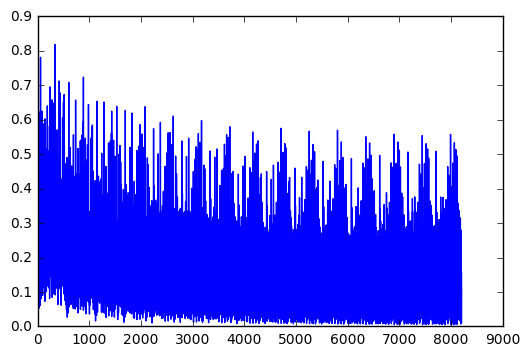

Train report
Batch 0
Batch 100
Batch 200
Batch 300
Batch 400
Batch 500
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      5166
          1       0.99      0.99      0.99      5982
          2       0.98      0.97      0.98      5198
          3       0.98      0.98      0.98      5329
          4       0.97      0.98      0.97      5055
          5       0.98      0.97      0.98      4759
          6       0.99      0.99      0.99      5171
          7       0.98      0.98      0.98      5478
          8       0.97      0.98      0.97      5083
          9       0.97      0.96      0.97      5279

avg / total       0.98      0.98      0.98     52500

('Accuracy', 0.9784571428571428)
Test report
Batch 0
Batch 100
             precision    recall  f1-score   support

          0       0.99      0.97      0.98      1737
          1       0.98      0.99      0.98      1895
          2       0.96      0.96      0.96      1792
          3   

In [13]:
plt.plot(loss_arr)
plt.show()

plt.plot(test_loss_arr)
plt.show()

make_classification_report(model, images_train, labels_train, images_test, labels_test)

Мы обучились, но графики выглядет не очень - дисперсия высокая. 

In [17]:
# Попробуем то же самое, но с ReLU
class Neuro_Arch4(nn.Module):
    def __init__(self):
        super(Neuro_Arch4, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 8, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 3, padding=1),
        )
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2 * 16 , 10), 
                                           nn.LogSoftmax())

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [18]:
model = Neuro_Arch4()
loss_fn = torch.nn.NLLLoss(size_average=True)


learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


loss_arr, test_loss_arr = learn_on_model( images_train, labels_train, model, loss_fn,images_test,\
                                                    labels_test,\
                                                    learning_rate,\
                                                    max_epoch_num=15, batch_size = 32)

Epoch 1 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Train Batch 1100
Train Batch 1200
Train Batch 1300
Train Batch 1400
Train Batch 1500
Train Batch 1600
Test Batch 0
Test Batch 100
Test Batch 200
Test Batch 300
Test Batch 400
Test Batch 500
Epoch 2 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Train Batch 1100
Train Batch 1200
Train Batch 1300
Train Batch 1400
Train Batch 1500
Train Batch 1600
Test Batch 0
Test Batch 100
Test Batch 200
Test Batch 300
Test Batch 400
Test Batch 500
Epoch 3 ...
Train Batch 0
Train Batch 100
Train Batch 200
Train Batch 300
Train Batch 400
Train Batch 500
Train Batch 600
Train Batch 700
Train Batch 800
Train Batch 900
Train Batch 1000
Train Batch 1100
Train Batch 1200
Train Batch 1300
Train Ba

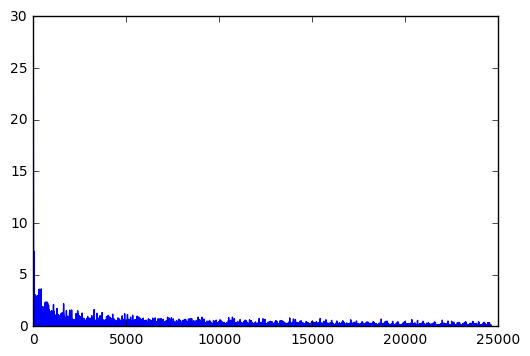

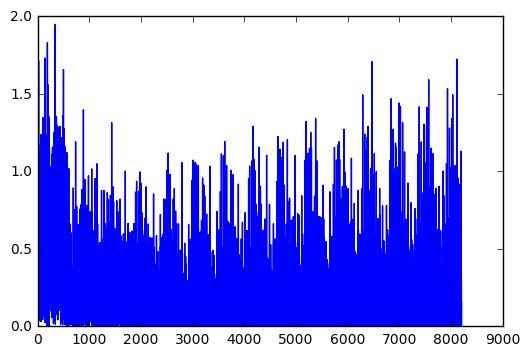

Train report
Batch 0
Batch 100
Batch 200
Batch 300
Batch 400
Batch 500
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      5166
          1       1.00      0.99      1.00      5982
          2       0.98      1.00      0.99      5198
          3       0.99      0.99      0.99      5329
          4       0.99      1.00      0.99      5055
          5       0.99      1.00      0.99      4759
          6       1.00      1.00      1.00      5171
          7       0.98      0.99      0.99      5478
          8       0.99      0.98      0.99      5083
          9       0.99      0.97      0.98      5279

avg / total       0.99      0.99      0.99     52500

('Accuracy', 0.99177142857142853)
Test report
Batch 0
Batch 100
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      1737
          1       0.99      0.98      0.98      1895
          2       0.96      0.97      0.97      1792
          3  

In [19]:
plt.plot(loss_arr)
plt.show()

plt.plot(test_loss_arr)
plt.show()

make_classification_report(model, images_train, labels_train, images_test, labels_test)

Качество обучения не улучшилось. Кроме того, видим, что наша сеть стала переобучаться. 

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару:

Все было замечательно) Понравились третья и четвертые лекции (забыл отметиться, потому напишу тоже здесь)